## Set up the environment

In [1]:
import pandas as pd
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from src.plotting import trim_axs
from tqdm import tqdm
pd.set_option('display.max_rows', None)


In [2]:
import os
os.environ["SUBJECTS_DIR"] = "/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling/data/raw/freesurfer"
os.environ["FREESURFER_HOME"] = "/Applications/freesurfer"

In [3]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_modeling'
interim_dir = f'{top_dir}/data/interim'
raw_dir = f'{top_dir}/data/raw'
figure_dir = f'{top_dir}/reports/figures'

## Model comparisons

In [4]:
import numpy as np
from nilearn import plotting, surface
import nibabel as nib
from src.tools import camera_switcher


def compute_surf_stats(prefix, sub, hemi):
    file = f'{prefix}_hemi-{hemi}.mgz'
    if not os.path.exists(file):
        cmd = '/Applications/freesurfer/bin/mri_vol2surf '
        cmd += f'--src {prefix}.nii.gz '
        cmd += f'--out {file} '
        cmd += f'--regheader sub-{sub} '
        cmd += f'--hemi {hemi} '
        cmd += '--projfrac 1'
        os.system(cmd)
    return surface.load_surf_data(file)


def load_surf_mesh(path, sub, hemi):
    return f'{path}/freesurfer/sub-{sub}/surf/{hemi}.inflated', \
            f'{path}/freesurfer/sub-{sub}/surf/{hemi}.sulc'


def plot_stats(surf_mesh, bg_map, surf_map, hemi_, figure_prefix,
                vmax=0.6, negative_values=False,
                cmap=sns.color_palette('magma', as_cmap=True), threshold = 1e-3):
    if hemi_ == 'lh':
        hemi_name = 'left'
    else:
        hemi_name = 'right'

    surf_map = np.nan_to_num(surf_map)
    if not negative_values:
        surf_map[surf_map < 0] = 0
        vmin = 0
    else:
        vmin = None

    fig = plotting.plot_surf_roi(surf_mesh=surf_mesh,
                                    roi_map=surf_map,
                                    bg_map=bg_map,
                                    threshold=threshold,
                                    vmax=vmax,
                                    vmin=vmin,
                                    engine='plotly',
                                    colorbar=True,
                                    cmap=cmap,
                                    hemi=hemi_name)
    fig.figure.write_html(f'{figure_prefix}_hemi-{hemi_}.html')

    for view in ['ventral', 'lateral', 'medial']:
        colorbar = True if view == 'medial' and hemi_ == 'rh' else False
        fig = plotting.plot_surf_roi(surf_mesh=surf_mesh,
                                        roi_map=surf_map,
                                        bg_map=bg_map,
                                        threshold=threshold,
                                        vmax=vmax,
                                        vmin=vmin,
                                        engine='plotly',
                                        colorbar=colorbar,
                                        view=view,
                                        cmap=cmap,
                                        hemi=hemi_name)
        fig.figure.update_layout(scene_camera=camera_switcher(hemi_, view),
                                    paper_bgcolor="rgba(0,0,0,0)",
                                    plot_bgcolor="rgba(0,0,0,0)")
        fig.figure.write_image(f'{figure_prefix}_view-{view}_hemi-{hemi_}.png')


In [5]:
scores = []

files = glob(f'{interim_dir}/VisionEncoding/*.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('model-')[-1]
    scores.append(df)

files = glob(f'{interim_dir}/LLMEncoding/*stripped_orig.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = file.split('/')[-1].split('.csv')[0].split('_perturb')[0].split('model-')[-1]
    scores.append(df)

files = glob(f'{interim_dir}/GLoVeEncoding/*stripped_orig.csv')
for file in files:
    df = pd.read_csv(file)
    df['model_uid'] = 'GLoVe'
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores.head()

,voxel_id,roi_name,stream_name,subj_id,reliability,i_index,j_index,k_index,layer_index,layer,score,model_uid
0,0,none,none,1,0.322961,2,33,31,1,Conv2d-2-1,0.233384,slip_vit_s_yfcc15m
1,1,none,none,1,0.340669,2,33,32,1,Conv2d-2-1,0.203303,slip_vit_s_yfcc15m
2,2,none,none,1,0.313496,2,34,35,1,Conv2d-2-1,0.324110,slip_vit_s_yfcc15m
3,3,none,none,1,0.254933,2,35,31,1,Conv2d-2-1,0.330897,slip_vit_s_yfcc15m
4,4,none,none,1,0.300477,2,36,36,1,Conv2d-2-1,0.361359,slip_vit_s_yfcc15m


In [7]:
for subj_id in tqdm(range(1,5), desc='Plotting subjects'):
    for model in ['all-MiniLM-L6-v2', 'slip_vit_s_simclr_yfcc15m']:
        subj_id_str = str(subj_id).zfill(2)
        stat_file = f'{interim_dir}/Plotting/sub-{subj_id_str}_model-{model}'
        plot_file = f'{figure_dir}/Plotting/sub-{subj_id_str}_model-{model}'

        img = nib.load(f'{raw_dir}/fmri_betas/sub-{subj_id_str}_space-T1w_desc-train-fracridge_data.nii.gz')

        dims = img.shape[:-1]
        header, affine = img.header, img.affine

        cur_df = scores.loc[(scores.model_uid == model) & (scores.subj_id == subj_id)]
        scores_arr = cur_df['score'].to_numpy()
        indices = cur_df[['i_index', 'j_index', 'k_index']].to_numpy()

        score_img = np.zeros(dims)
        score_img[indices[:, 0], indices[:, 1], indices[:, 2]] = scores_arr
        score_img = nib.Nifti1Image(score_img, affine=affine, header=header)
        nib.save(score_img, f'{stat_file}.nii.gz')

        for hemi in ['lh', 'rh']:
            surf = compute_surf_stats(stat_file, subj_id_str, hemi)
            inflated, sulcus = load_surf_mesh(raw_dir, subj_id_str, hemi)
            plot_stats(inflated, sulcus, surf, hemi, plot_file)

Plotting subjects:   0%|          | 0/4 [00:00<?, ?it/s]/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning: choosing both vmin and a threshold is not allowed; setting vmin to 0
  warnings.warn('choosing both vmin and a threshold is not allowed; '
/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

Plotting subjects:  25%|██▌       | 1/4 [01:04<03:14, 64.84s/it]/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:85: UserWarning:

choosing both vmin and a threshold is not allowed; setting vmin to 0

/Applications/anacon

In [8]:
vm = 'slip_vit_s_simclr_yfcc15m'
lm = 'all-MiniLM-L6-v2'

for subj_id in tqdm(range(1,5), desc='Plotting subjects'):
    subj_id_str = str(subj_id).zfill(2)
    stat_file = f'{interim_dir}/Plotting/sub-{subj_id_str}_model-visminuslang'
    plot_file = f'{figure_dir}/Plotting/sub-{subj_id_str}_model-visminuslang'

    img = nib.load(f'{raw_dir}/fmri_betas/sub-{subj_id_str}_space-T1w_desc-train-fracridge_data.nii.gz')

    dims = img.shape[:-1]
    header, affine = img.header, img.affine

    vision_df = scores.loc[(scores.model_uid == vm) & (scores.subj_id == subj_id)]
    language_df = scores.loc[(scores.model_uid == lm) & (scores.subj_id == subj_id)]
    scores_arr = vision_df['score'].to_numpy() - language_df['score'].to_numpy()
    indices = vision_df[['i_index', 'j_index', 'k_index']].to_numpy()

    score_img = np.zeros(dims)
    score_img[indices[:, 0], indices[:, 1], indices[:, 2]] = scores_arr
    score_img = nib.Nifti1Image(score_img, affine=affine, header=header)
    nib.save(score_img, f'{stat_file}.nii.gz')

    for hemi in ['lh', 'rh']:
        surf = compute_surf_stats(stat_file, subj_id_str, hemi)
        inflated, sulcus = load_surf_mesh(raw_dir, subj_id_str, hemi)
        plot_stats(inflated, sulcus, surf, hemi, plot_file, vmax=.4,
                   negative_values=True,
                   cmap=sns.color_palette('icefire', as_cmap=True))

Plotting subjects:   0%|          | 0/4 [00:00<?, ?it/s]/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning:

you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning:

vmin cannot be chosen when cmap is symmetric

Plotting subjects:  25%|██▌       | 1/4 [00:32<01:36, 32.08s/it]/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:76: UserWarning:

you have specified symmetric_cmap=False but the map contains negative values; setting symmetric_cmap to True

/Applications/anaconda3/envs/fmri_modeling/lib/python3.10/site-packages/nilearn/plotting/js_plotting_utils.py:81: UserWarning:

vmin cannot be chosen when cmap is symmetric

Plotting subjects:  50%|█████     | 2/4 [01:04<01:04, 32

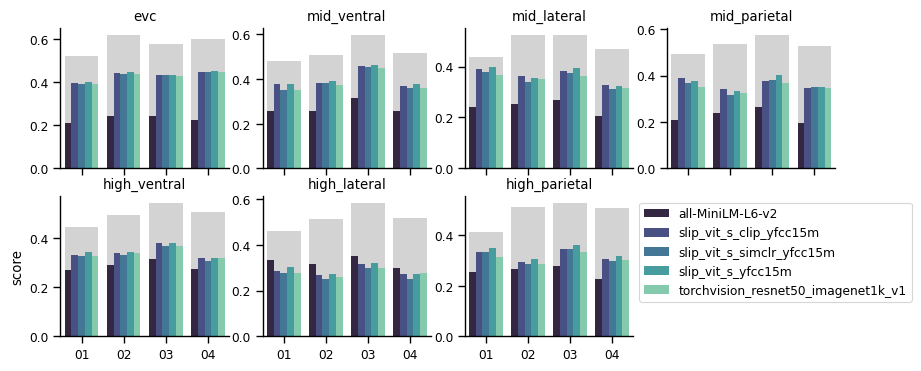

In [6]:
streams = ['evc']
streams += [f'{level}_{stream}' for level in ['mid', 'high'] for stream in ['ventral', 'lateral', 'parietal']]
stream_scores = scores.loc[scores.stream_name != 'none'].reset_index(drop=True)
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
stream_scores['stream_name'] = stream_scores['stream_name'].astype(cat_type)
avg_stream_scores = stream_scores.groupby(['stream_name', 'model_uid', 'subj_id']).mean(numeric_only=True).reset_index()

sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, figsize=(10, 4))
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = avg_stream_scores.groupby('stream_name')
subjs = ['01', '02', '03', '04']
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='subj_id', y='reliability', color='lightgray',
               data=stream_df, ax=ax, errorbar=None,
               zorder=0)
   sns.barplot(x='subj_id', y='score',
               hue='model_uid', palette='mako',
                  data=stream_df, ax=ax, errorbar=None,
                  zorder=1)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(subjs, ha='center')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

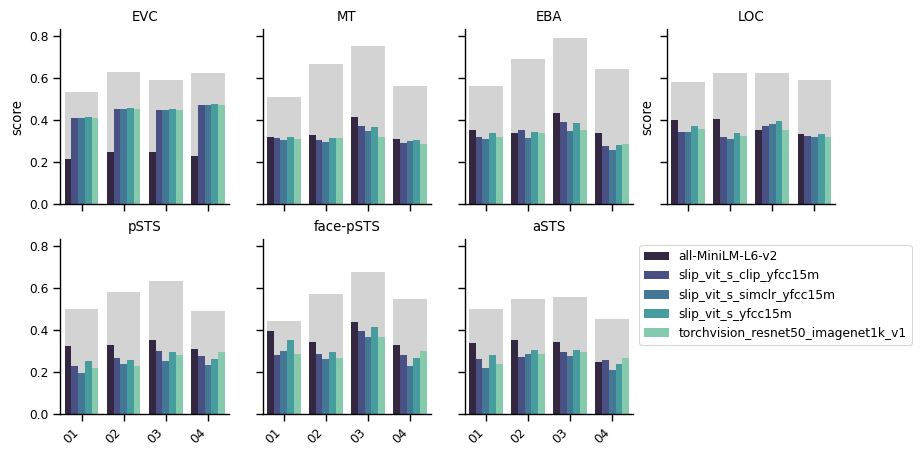

In [12]:
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'face-pSTS', 'aSTS']
roi_scores = scores.loc[scores.roi_name != 'none'].reset_index(drop=True)
cat_type = pd.CategoricalDtype(categories=rois, ordered=True)
roi_scores['roi_name'] = roi_scores['roi_name'].astype(cat_type)
avg_roi_scores = roi_scores.groupby(['roi_name', 'model_uid', 'subj_id']).mean(numeric_only=True).reset_index()

sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(10, 5))
trim_axs(axes, len(rois))
axes = axes.flatten()
roi_group = avg_roi_scores.groupby('roi_name')
subjs = ['01', '02', '03', '04']
for ax, (roi, roi_df) in zip(axes, roi_group):
   sns.barplot(x='subj_id', y='reliability', color='lightgray',
               data=roi_df, ax=ax, errorbar=None,
               zorder=0)
   sns.barplot(x='subj_id', y='score',
               hue='model_uid', palette='mako',
                  data=roi_df, ax=ax, errorbar=None,
                  zorder=1)
   if roi not in ['EVC', 'LOC']:
      ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(subjs, rotation=45, ha='right')
   ax.set_title(roi)
   ax.set_xlabel('')
   if roi != 'aSTS':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()

## SBERT perturbation experiments

In [ ]:
perturbations = ['none', 'corrected_unmasked', 'shuffle_sentence', 
                'mask_all_nouns', 'mask_all_verbs',
                'mask_main_subjects', 'mask_main_verb_phrase', 
                'mask_direct_objects', 'mask_prep_phrases']

In [ ]:
scores = []
for perturb in perturbations:
    file = f'{interim_dir}/LLMEncoding/model-all-MiniLM-L6-v2_perturbation-{perturb}.csv'
    df = pd.read_csv(file)
    df['perturbation'] = perturb
    scores.append(df)
    
scores = pd.concat(scores).reset_index(drop=True)
scores = scores[scores['stream_name'] != 'none'].reset_index(drop=True)
scores['model_layer_index'] = scores.model_layer_index.astype('str')
scores.set_index(['perturbation', 'model_layer_index', 'stream_name'], inplace=True)
scores.sort_index(inplace=True)
scores.head()

model_layer  subj_id  \
perturbation       model_layer_index stream_name                           
corrected_unmasked 1                 EVC           BertModel-S1        1   
                                     EVC           BertModel-S1        2   
                                     EVC           BertModel-S1        3   
                                     EVC           BertModel-S1        4   
                                     high_lateral  BertModel-S1        1   

                                                      score method  
perturbation       model_layer_index stream_name                    
corrected_unmasked 1                 EVC           0.045357  ridge  
                                     EVC           0.096012  ridge  
                                     EVC           0.068637  ridge  
                                     EVC           0.054093  ridge  
                                     high_lateral  0.134146  ridge

In [ ]:
avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()
iter_scores = avg_scores.groupby(['perturbation', 'stream_name'])
max_scores = []
for (model_uid, stream), stream_df in iter_scores:
    idx = stream_df['score'].idxmax()
    score = tuple(stream_df.loc[idx, ['perturbation', 'model_layer_index', 'stream_name']].to_list())
    max_scores.append(scores.loc[score])
max_scores = pd.concat(max_scores).reset_index()
max_scores.head()

/var/folders/bp/2lmtx6qs4rzbksq18mtrbrjsfr_flb/T/ipykernel_24860/37540273.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_scores = scores.reset_index().groupby(['perturbation', 'model_layer_index', 'stream_name']).mean().reset_index()


,perturbation,model_layer_index,stream_name,model_layer,subj_id,score,method
0,corrected_unmasked,91,EVC,LayerNorm-6-35,1,0.076571,ridge
1,corrected_unmasked,91,EVC,LayerNorm-6-35,2,0.103687,ridge
2,corrected_unmasked,91,EVC,LayerNorm-6-35,3,0.091580,ridge
3,corrected_unmasked,91,EVC,LayerNorm-6-35,4,0.084788,ridge
4,corrected_unmasked,92,high_lateral,BertIntermediate-4-14,1,0.166583,ridge


In [ ]:
cat_type = pd.CategoricalDtype(categories=streams, ordered=True)
max_scores['stream_name'] = max_scores['stream_name'].astype(cat_type)

cat_type = pd.CategoricalDtype(categories=perturbations, ordered=True)
max_scores['perturbation'] = max_scores['perturbation'].astype(cat_type)

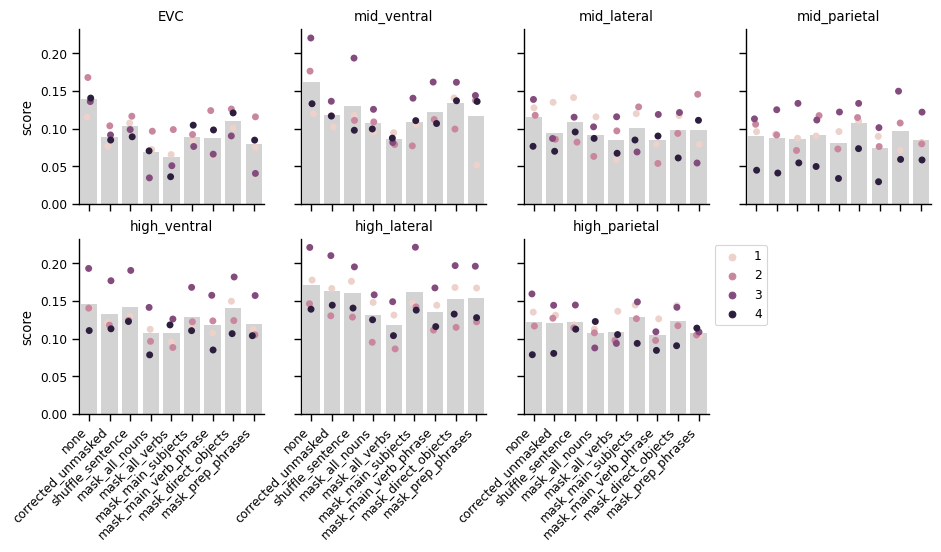

In [ ]:
sns.set_context(context='paper')
_, axes = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(11,5))
trim_axs(axes, len(streams))
axes = axes.flatten()
stream_group = max_scores.groupby('stream_name')
for ax, (stream, stream_df) in zip(axes, stream_group):
   sns.barplot(x='perturbation', y='score',
                  data=stream_df, ax=ax,
                  color='lightgray', errorbar=None)
   sns.stripplot(x='perturbation', y='score',
                  hue='subj_id', dodge=False,
                  data=stream_df, ax=ax)
   if stream not in ['EVC', 'high_ventral']:
         ax.set_ylabel('')
   ax.spines['top'].set_visible(False)
   ax.spines['right'].set_visible(False)
   ax.set_xticklabels(perturbations, rotation=45, ha='right')
   ax.set_title(stream)
   ax.set_xlabel('')
   if stream != 'high_parietal':
      ax.legend().set_visible(False)
   else:
      ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# plt.tight_layout()